In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score


2025-04-19 16:06:41.700939: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 16:06:41.704808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 16:06:41.754571: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 16:06:41.755326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 16:06:42.821664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [8]:
csv = "../../data/contaminated/contaminated_data_bis.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies_bis.npy").flatten().tolist()

In [3]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
def vetorisation_sbert(data, indice_anomalie=None):
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : normal)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

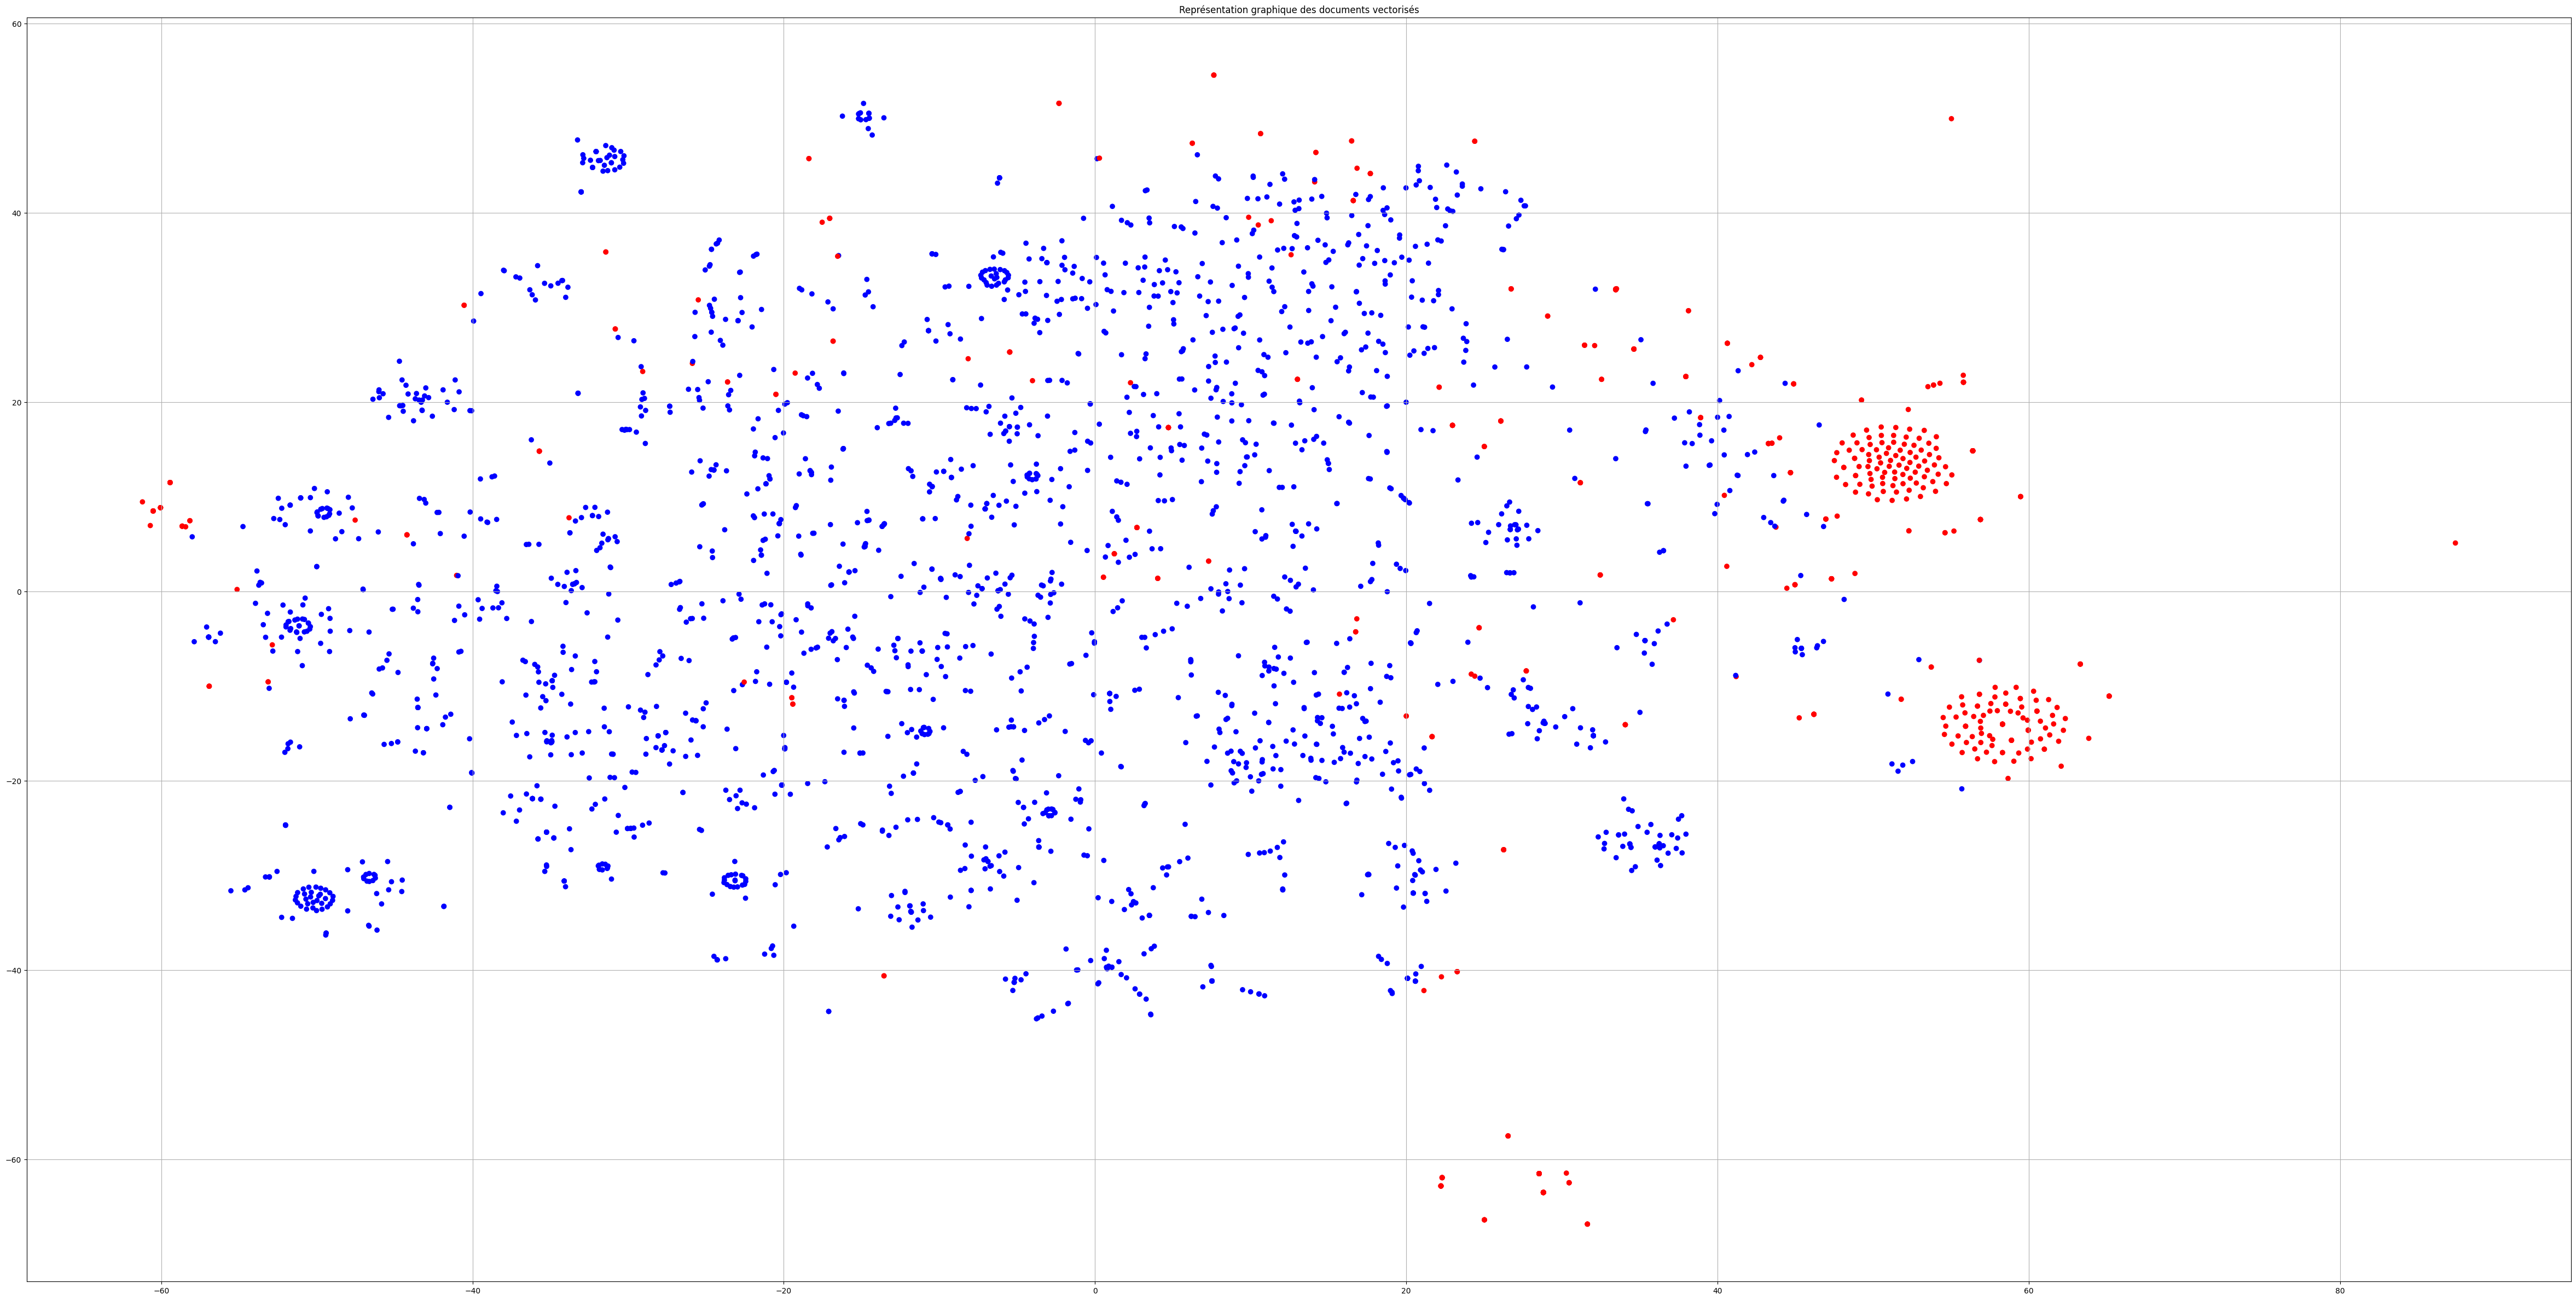

In [4]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),     # Normalisation batch sur vecteurs
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [19]:
anomalie_tensor = torch.tensor(anomalie_sb, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=anomalie_sb.shape[1], latent_dim = 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0031
Epoch 2/50, Loss: 0.0005
Epoch 3/50, Loss: 0.0008
Epoch 4/50, Loss: 0.0005
Epoch 5/50, Loss: 0.0007
Epoch 6/50, Loss: 0.0007
Epoch 7/50, Loss: 0.0005
Epoch 8/50, Loss: 0.0025
Epoch 9/50, Loss: 0.0012
Epoch 10/50, Loss: 0.0005
Epoch 11/50, Loss: 0.0004
Epoch 12/50, Loss: 0.0004
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0005
Epoch 15/50, Loss: 0.0004
Epoch 16/50, Loss: 0.0005
Epoch 17/50, Loss: 0.0004
Epoch 18/50, Loss: 0.0010
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0003
Epoch 21/50, Loss: 0.0004
Epoch 22/50, Loss: 0.0004
Epoch 23/50, Loss: 0.0004
Epoch 24/50, Loss: 0.0005
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0005
Epoch 29/50, Loss: 0.0016
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0004
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0004
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0005
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0004
Epoch 39/50, Loss: 0.


🔥 Meilleur seuil trouvé : 0.000331
📈 F1-score optimal : 0.4577

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.86      0.87      0.87      2290
    Anomalie       0.46      0.45      0.46       572

    accuracy                           0.78      2862
   macro avg       0.66      0.66      0.66      2862
weighted avg       0.78      0.78      0.78      2862

AUC ROC : 0.6609
Average precision : 0.3186


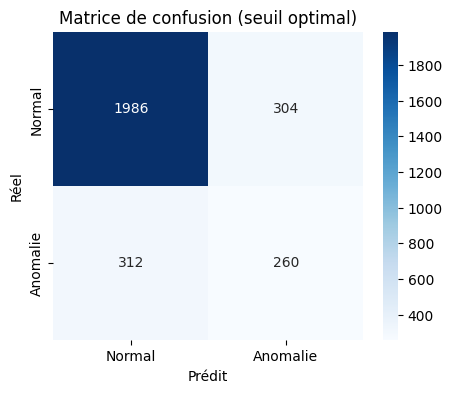

In [20]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(anomalie_sb, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.zeros(anomalie_sb.shape[0])
labels[indices] = 1
labels = labels.astype(int)

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [21]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    2862.000000
mean        0.000235
std         0.000110
min         0.000068
25%         0.000152
50%         0.000209
75%         0.000303
max         0.000705
Name: MSE, dtype: float64


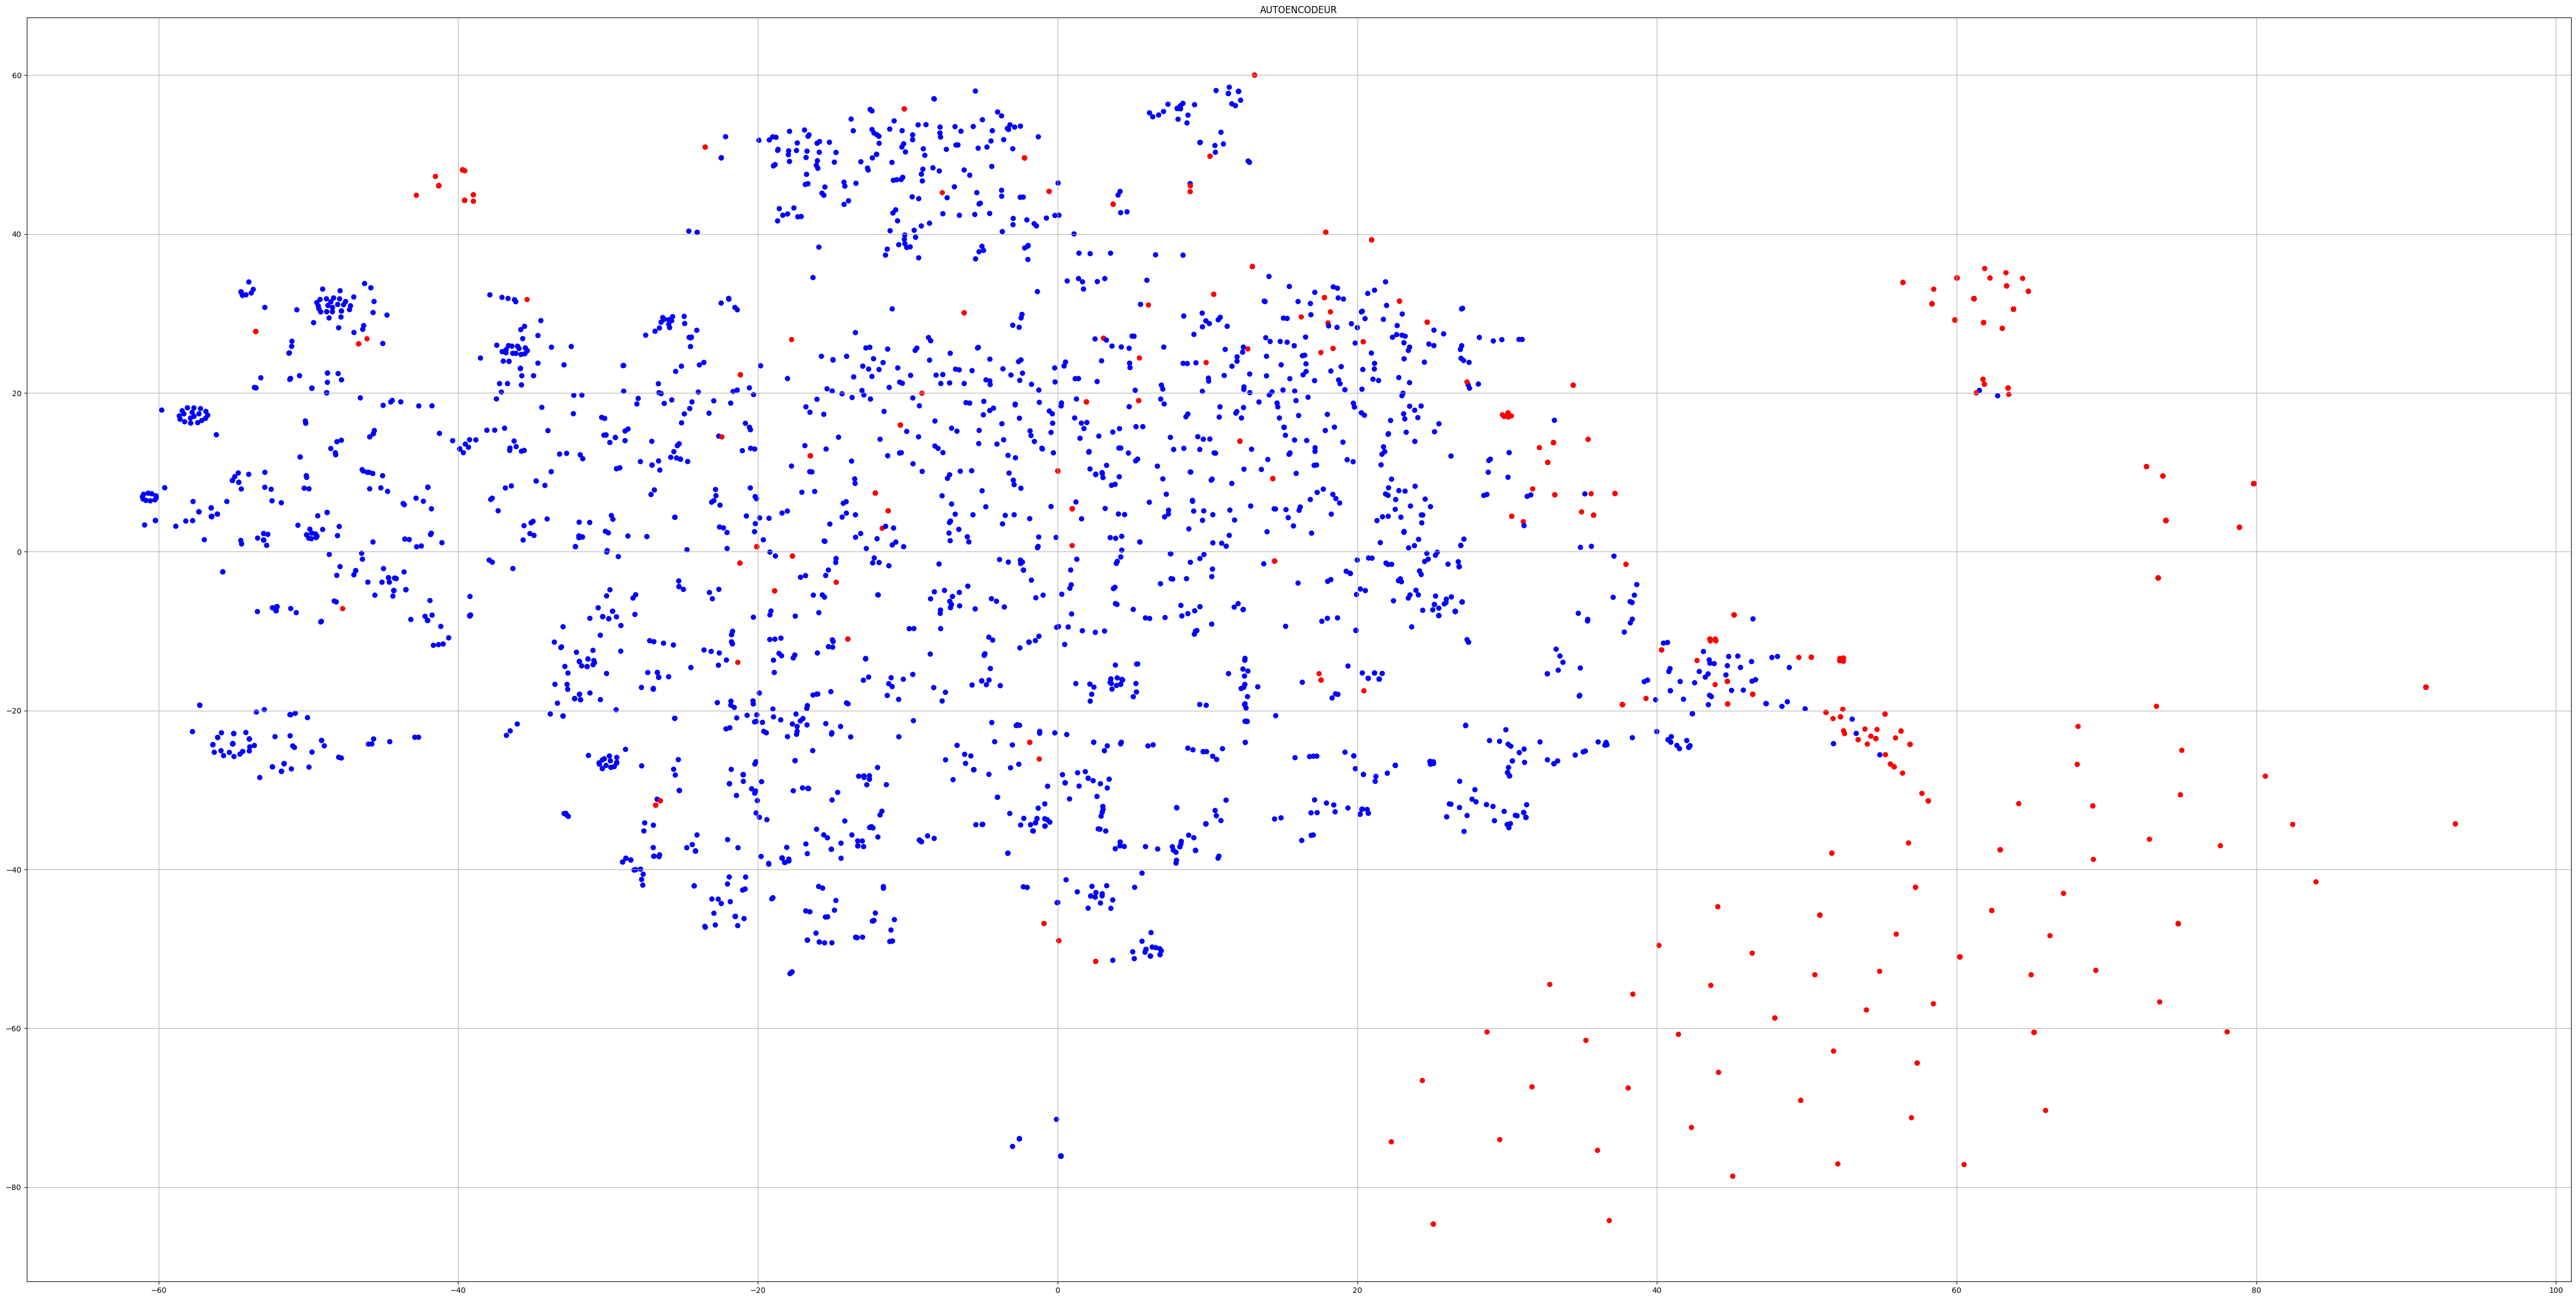

In [22]:
tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
reconstructed_2d = tsne.fit_transform(reconstructions)  # appliquer t-SNE

# couleurs des points ( rouge : anomalie, bleu : noraml)
couleurs = ['b'] * len(anomalie_sb)
for i in indices:
    if 0 <= i < len(anomalie_sb): 
        couleurs[i] = 'r'

# affichage graphique des données dans l'espace 2D
plt.figure(figsize=(60, 30)) 
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], c=couleurs, marker='o') 

plt.title("AUTOENCODEUR")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()

In [23]:
isolation_forest = IsolationForest()
isolation_forest.fit(anomalie_sb)

IsolationForest()

In [24]:
i_forest = isolation_forest.decision_function(anomalie_sb)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       1.00      0.04      0.07      2290
    Anomalie       0.21      1.00      0.34       572

    accuracy                           0.23      2862
   macro avg       0.60      0.52      0.21      2862
weighted avg       0.84      0.23      0.12      2862

AUC ROC : 0.5181
Average precision : 0.2058


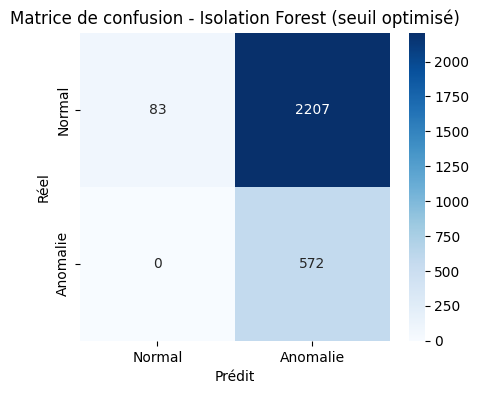

In [25]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [38]:
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05) 
oc_svm.fit(anomalie_sb)

OneClassSVM(nu=0.05)

In [39]:
svm_pred = oc_svm.decision_function(anomalie_sb)
svm_scores = -svm_pred #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.87      0.12      0.21       905
    Anomalie       0.21      0.93      0.34       226

    accuracy                           0.28      1131
   macro avg       0.54      0.52      0.27      1131
weighted avg       0.74      0.28      0.23      1131

AUC ROC : 0.5232
Average precision : 0.2075


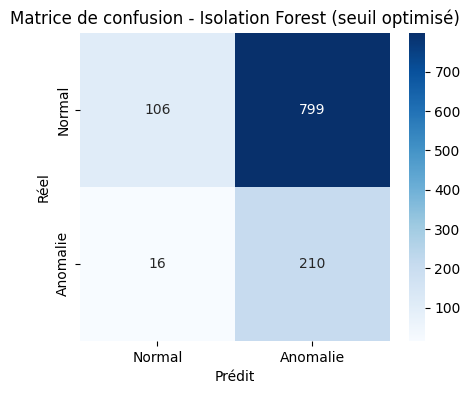

In [40]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")
# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()